Initialisation

In [27]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

import sys
print(sys.setrecursionlimit(20000))

N = 10 #Number of points

None


Dataset generation

In [2]:
def generateB(n):
    """
    Return list of n list of 2 elements
    """
    return rd.uniform(size=(n, 2))
    

In [3]:
def generateA(n):

    A=generateB(n-4)

    #adding the corner
    A= np.append(A,[[0,0]],axis=0)
    A= np.append(A,[[0,1]],axis=0)
    A= np.append(A,[[1,0]],axis=0)
    A= np.append(A,[[1,1]],axis=0)

    #rotating the set
    angle = rd.uniform() * 2 * np.pi
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    A = A @ rotation_matrix

    # Shuffle the points
    np.random.shuffle(A)
    return A


In [4]:
def generateC(n,r):
    C=[]
    while np.size(C,0)<n:
        x,y=rd.uniform(-r,r),rd.uniform(-r,r)
        if x**2+y**2<=r**2:
            C.append([x,y])
    return np.array(C)

In [5]:
def generateD(n,r):
    D=[]
    for i in range(n):
        angle = rd.uniform()*2*np.pi
        D.append([r*np.cos(angle),r*np.sin(angle)])
    return np.array(D)


Sweeping

In [6]:
def sort(L):
    return L[L[:,0].argsort()]

In [7]:
def tri_fusion(L):
    if np.size(L, axis=0) == 1:
        return L
    else:
        return fusion(tri_fusion(np.copy(L[:np.size(L, axis=0)//2,:])) , tri_fusion(np.copy(L[np.size(L, axis=0)//2:,:])))

def fusion(A,B):
    if np.size(A, axis=0) == 0:
        return B
    elif np.size(B, axis=0) == 0:
        return A
    elif A[0][0] <= B[0][0]:
        return np.append(np.array([A[0]]), fusion(A[1:,:],B), axis=0)
    else:
        return np.append(np.array([B[0]]), fusion(B[1:,:],A), axis=0)

In [8]:
print(tri_fusion(generateA(20)))

[[-1.22481375  0.70698747]
 [-1.1059288   0.43451582]
 [-0.96590061 -0.25891314]
 [-0.91716587  0.47755983]
 [-0.87899976  0.74664472]
 [-0.84168578  0.74200956]
 [-0.71532634  0.47250256]
 [-0.65106452 -0.05317968]
 [-0.64111911  0.81650144]
 [-0.63367325  0.22934874]
 [-0.62677178 -0.15503065]
 [-0.58535115  0.05705268]
 [-0.5312623   0.76756836]
 [-0.43301217  0.08561759]
 [-0.42918596  0.2829599 ]
 [-0.40566972  0.47208448]
 [-0.25891314  0.96590061]
 [-0.2498154   0.81940012]
 [-0.24456881  0.42256749]
 [ 0.          0.        ]]


In [9]:
def orientiation_triangle(A,B,C):
    determinent = (B[1] - A[1]) * (C[0] - B[0]) - (B[0] - A[0]) * (C[1] - B[1])
    if determinent >= 0:
      return "clockwise"
    else:
        return "counter-clockwise"

In [10]:
def view_triangle():
    A = [1,0]
    B = [0,1]
    C = [1,1]
    plt.plot(A[0], A[1], marker=".")
    plt.text(A[0], A[1],'A',horizontalalignment='right')
    plt.plot(B[0], B[1], marker="X", markersize=10)
    plt.text(B[0], B[1],'B',horizontalalignment='right')
    plt.plot(C[0], C[1], marker="X", markersize=10)
    plt.text(C[0], C[1],'C',horizontalalignment='right')

    print(orientiation_triangle(A,B,C))
    plt.show()

In [11]:
def sweeping_algorithm_upper(Dataset):
    chain=[]

    #The first point is a fake one so we ensure that we always have a convex shape
    chain.append([Dataset[0][0], Dataset[0][1]-1])

    chain.append(Dataset[0])
    for i in range(1,np.size(Dataset, axis=0)):
        q = chain[-1]
        p = chain[-2]
        cursor = Dataset[i]
    
        # Comparision of the sens of the angle
        while orientiation_triangle(p,q,cursor) != "clockwise" and len(chain) > 2:
            chain.pop()
            q = chain[-1]
            p = chain[-2]

        # Adding the cursor point in the chain
        chain.append(cursor)
    
    del chain[0]
    return chain

    
def sweeping_algorithm_lower(Dataset):
    chain=[]

    #The first point is a fake one so we ensure that we always have a convex shape
    chain.append([Dataset[0][0], Dataset[0][1]-1])

    chain.append(Dataset[0])
    for i in range(1,np.size(Dataset, axis=0)):
        q = chain[-1]
        p = chain[-2]
        cursor = Dataset[i]
    
        # Comparision of the sens of the angle
        while orientiation_triangle(p,q,cursor) == "clockwise" and len(chain) > 2:
            chain.pop()
            q = chain[-1]
            p = chain[-2]

        # Adding the cursor point in the chain
        chain.append(cursor)
    
    del chain[0]
    return chain

In [12]:
def affichage_chaine(Dataset):
    #Dataset = sort(Dataset)
    Dataset = tri_fusion(Dataset)
    chain_lower = sweeping_algorithm_lower(Dataset)
    chain_upper = sweeping_algorithm_upper(Dataset)

    #Plot des points
    for i in range(np.size(Dataset, axis=0)):
        plt.plot(Dataset[i][0], Dataset[i][1], marker=".")
    
    #Plot of seigment
    for i in range(len(chain_lower)-1):
        plt.plot([chain_lower[i][0],chain_lower[i+1][0]], [chain_lower[i][1],chain_lower[i+1][1]], 'k-')
    for i in range(len(chain_upper)-1):
        plt.plot([chain_upper[i][0],chain_upper[i+1][0]], [chain_upper[i][1],chain_upper[i+1][1]], 'k-')
    
    plt.grid()
    plt.show()


Complexity

100%|██████████| 102/102 [00:34<00:00,  2.92it/s]


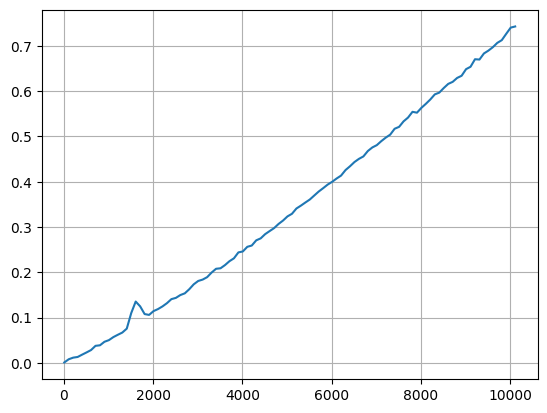

In [28]:
def print_complexity():
    i=int(1)
    s=int(1e2)
    step=5*int(1e1)

    i2=int(1e2)
    s2=int(1e4)
    step2=int(1e2)

    i3=int(1e4)
    s3=int(1e6)
    step3=2*int(1e4)

    R=list(range(i,s,step))+list(range(i2,s2,step2))+list(range(i3,s3,step3))
    
    n = []
    time_table = []
    for i in tqdm(range(10,10200,100)):
        t_init = time.time()
        A = generateA(i)
        A = tri_fusion(A)
        chain_lower = sweeping_algorithm_lower(A)
        chain_upper = sweeping_algorithm_upper(A)
        t_final = time.time()
        n.append(i)
        time_table.append(t_final-t_init)
        
    plt.plot(n, time_table)
    plt.grid()
    plt.show()

print_complexity()

Output sensitive algorithm

In [14]:
def median(L):
    if len(L)<=5:
        return median_sous_liste(L)
    else:
        return selection(L, len(L)//2)

def selection(L,k):
    if len(L)<=5:
        return median_sous_liste(L)
    else:
        liste_of_mediane=[median_sous_liste(L[i:i+5]) for i in range(0, len(L), 5)]
        mediane_of_mediane = selection(liste_of_mediane, len(liste_of_mediane)//2)
        
        under = [x for x in L if x<mediane_of_mediane]
        over = [x for x in L if x>= mediane_of_mediane]
        
        if k < len(under):
            return selection(under, k)
        elif k == len(under):
            return mediane_of_mediane
        else:
            return selection(over, k - len(under) - 1)


def median_sous_liste(L):
    L = np.sort(L)
    if len(L)==5 :
        return L[2]
    elif len(L) == 4 :
        return (L[1]+L[2])/2
    elif len(L)== 3 :
        return L[1]
    elif len(L) == 2 : 
        return (L[0]+L[1])/2
    else :
        return L[0]

In [15]:
def above(p1,p2,p3):
    """
    Tells if p1 is above the line defined by p2 and p3
    """
    def function(x):
        return ((p3[1]-p2[1])/(p3[0]-p2[0])*(x-p3[0])+p3[1])
    if p1[1]> function(p1[0]):
        return True
    else:
        return False

In [16]:
def find_basis_plot(dataset):
    mediane = median(np.copy(dataset[:,0]).tolist())
    points_copy = np.copy(dataset)
    
    #initialization of p1 and p2
    p1=np.copy(points_copy[0,:])
    i=0
    while p1[0]>=mediane:
        i=i+1
        p1=np.copy(points_copy[i,:])
    points_copy= np.delete(points_copy,i,axis=0)     

    i=0
    p2=np.copy(points_copy[0,:])
    while p2[0]<mediane:
        i=i+1
        p2=np.copy(points_copy[i,:])
    points_copy= np.delete(points_copy,i,axis=0)

    #Shuffling so we pick up a random point
    rd.shuffle(points_copy)

    #Applying th algorithm
    left=np.array([p1])
    right=np.array([p2])

    while np.size(points_copy, axis=0)>0:
        p3=np.copy(points_copy[0,:])
        points_copy= np.delete(points_copy,0,axis=0)
        if p3[0]>=mediane:
            right = np.append(right,[p3],axis=0)
            if above(p3,p1,p2):
                max_pente =  np.inf
                indice_max_pente = -1
                for i in range(len(left)):
                    pente = (p3[1]-left[i][1])/(p3[0]-left[i][0])
                    if pente<max_pente:
                        max_pente=pente
                        indice_max_pente=i
                    p1=np.copy(left[indice_max_pente,:])
                    p2=np.copy(p3)
        else:
            left = np.append(left,[p3],axis=0)
            if above(p3,p1,p2):
                min_pente= -np.inf
                indice_min_pente = -1
                for i in range(len(right)):
                    pente = (right[i][1]-p3[1])/(right[i][0]-p3[0])
                    if pente>min_pente:
                        min_pente=pente
                        indice_min_pente=i
                    p1=np.copy(p3)
                    p2=np.copy(right[indice_min_pente,:])
    return p1,p2


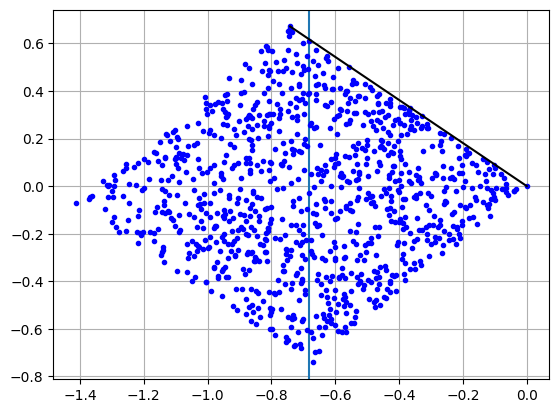

In [17]:
def print_find_basis(dataset):
    #Plot des points
    plt.axvline(np.median(dataset[:,0]))
    for i in range(np.size(dataset, axis=0)):
       plt.plot(dataset[i][0], dataset[i][1], marker=".", color="b")

    p1,p2 =find_basis_plot(dataset)
    
    
    plt.plot([p1[0],p2[0]],[p1[1],p2[1]], 'k-')
    plt.grid()
    plt.show()

print_find_basis(generateA(1000))

In [18]:
def hull_by_basis(dataset):
    if np.size(dataset, axis=0)==2:
        return [dataset[0],dataset[1]]
    elif np.size(dataset, axis=0)==1:
        return [dataset[0]]
    else :
        l,r = find_basis_plot(dataset)
        left = []
        right = []
        for p in range(np.size(dataset, axis=0)):
            if dataset[p][0]<=l[0]:
                left.append(dataset[p])
            elif dataset[p][0]>= r[0]:
                right.append(dataset[p])
        left = np.array(left)
        right = np.array(right)
        return hull_by_basis(left)+ [l,r] + hull_by_basis(right)



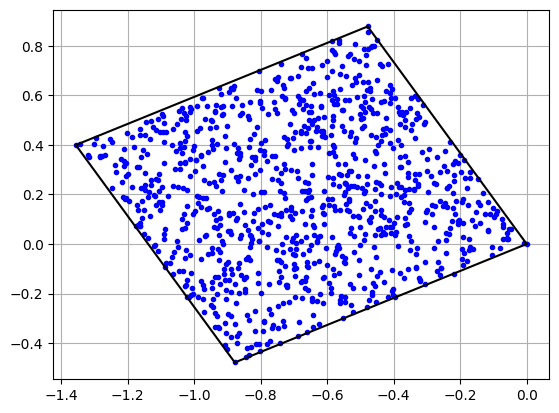

In [43]:
def print_hull_by_basis(dataset):
   for i in range(np.size(dataset, axis=0)):
      plt.plot(dataset[i][0], dataset[i][1], marker=".", color="b")
   #upper hull

   hull = hull_by_basis(dataset)
   for i in range(len(hull)-1):
      plt.plot([hull[i][0],hull[i+1][0]],[hull[i][1],hull[i+1][1]], 'k-')
   
   #lower hull
   dataset = np.dot(dataset, np.array([[1,0],[0,-1]]))
   hull=hull_by_basis(dataset)
   for i in range(len(hull)-1):
      plt.plot([hull[i][0],hull[i+1][0]],[-hull[i][1],-hull[i+1][1]], 'k-')

   plt.grid()
   plt.show()

print_hull_by_basis(generateA(1000))